In [5]:
!pip install --upgrade jupyter
!pip install pyts
!pip install nbformat>=4.2.0
!pip show ipython
!pip show nbformat
!pip install --upgrade plotly

%pip install yfinance

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Name: ipython
Version: 8.24.0
Summary: IPython: Productive Interactive Computing
Home-page: 
Author: The IPython Development Team
Author-email: ipython-dev@python.org
License: BSD-3-Clause
Location: c:\users\sergio\aaa\module_25\req-act-25-3-project-jp\.venv\lib\site-packages
Requires: colorama, decorator, exceptiongroup, jedi, matplotlib-inline, prompt-toolkit, pygments, stack-data, traitlets, typing-extensions
Required-by: ipykernel, ipywidgets, jupyter-console
Name: nbformat
Version: 5.10.4
Summary: The Jupyter Notebook format
Home-page: 
Author: 
Author-email: Jupyter Development Team <jupyter@googlegroups.com>
License: BSD 3-Clause License
        
        - Copyright (c) 2001-2015, IPython Development Team
        - Copyright (c) 2015-, Jupyter Development Team
        
        All rights reserved.
        
        Redistribution and us

In [6]:
from __future__ import print_function

import os

import torch
print(torch.__version__)
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from math import floor

from pyts.image import GramianAngularField
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import yfinance as yf

import torch.backends.cudnn

#set gpu env
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device",device)
print("cuda version",torch.version.cuda)

2.3.0+cu121
Device cuda:0
cuda version 12.1


## Import Financial Data

In [7]:
#close price time period
start_date = '2021-10-01'
end_date = '2023-12-01'

In [8]:
ticker = 'SIVBQ'
dataset = yf.download(ticker, start=start_date, end=end_date, interval='1d')

print("num rows",dataset.shape[0])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print("Num rows for df Close col",len(dataset['Close'].dropna()))
print(dataset)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

[*********************100%%**********************]  1 of 1 completed

num rows 524
Num rows for df Close col 524
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-10-01  650.000000  669.570007  648.065002  664.530029  664.530029   
2021-10-04  663.989990  669.000000  645.729797  649.349976  649.349976   
2021-10-05  657.909973  669.174988  652.072571  665.380005  665.380005   
2021-10-06  654.039978  663.919983  643.219971  659.849976  659.849976   
2021-10-07  670.929993  679.000000  663.280029  665.559998  665.559998   
2021-10-08  670.594910  670.950012  663.090027  670.489990  670.489990   
2021-10-11  678.000000  692.210022  666.469971  666.510010  666.510010   
2021-10-12  663.349976  666.940002  650.289978  659.090027  659.090027   
2021-10-13  659.090027  668.099976  647.849976  667.719971  667.719971   
2021-10-14  676.760010  685.640015  673.000000  683.890015  683.890015   
2021-10-15  694.059998  695.590027  679.159973  690.330017  690.33001

## Clean dataset

Drop row if column is either NaN or missing

In [9]:
dataset.dropna(how='any', inplace=True)

## Generate Gramian angular field (GAF) images from time series data 
Uses popular time series imaging algorithm in [pyts' GramianAngularField method](https://pyts.readthedocs.io/en/stable/auto_examples/image/plot_single_gaf.html)

GAF represents time series in a polar coordinate system instead of the typical Cartesian coordinates by considering the trigonometric sum or difference between stock prices and calculate the correlation within different time intervals. [Source.](https://towardsdatascience.com/rgb-gaf-image-a-possible-solution-to-one-weak-point-of-gramian-angular-field-imaging-ffc6b31edfbe)

[Making Gram matrix CNN ready](https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3)

The dot product operation in GAF provides us with the similarity between datapoints. Since GAF provides the combination of the datapoints requested, the dot product combination of 32 data points yields 1024 points in an image. Since we request GAF images of size 32x32, we can calculate the number of images GAF will generate.

In [10]:
def generate_gaf_images(dataset, gaf_img_sz=32, method="summation", sample_range=(0,1)):
    #print("len data series received:",len(dataset),"size",dataset.size)

    #determine num of gaf_img_szX images with gaf_img_sz datapoints
    num_images_to_generate = floor(len(dataset) / gaf_img_sz)
    #print("num_images_to_generate",num_images_to_generate)
    
    #reshape dataset into number of images
    dataset = dataset[:num_images_to_generate*gaf_img_sz].reshape(num_images_to_generate, gaf_img_sz)
    #print("data in GAF",dataset)
    
    price_list=[]
    for i in range(num_images_to_generate):
        price_list.append(np.mean(dataset[i]))
    #print("prices in GAF",price_list)
    #print("image_size",gaf_img_sz)
    
    gaf = GramianAngularField(image_size=gaf_img_sz, method=method, sample_range=sample_range)
    gaf_images= gaf.fit_transform(dataset)
    print("gaf_image",gaf_images.shape)
    
    return gaf_images, price_list

## Visualize Closing Price for one image in GAF
A darker patch indicates lower correlation between the different elements of the price time series, possibly due to higher volatility or noise. The opposite is true for the lighter patches.

524
gaf_image (16, 32, 32)
 (16, 32, 32)


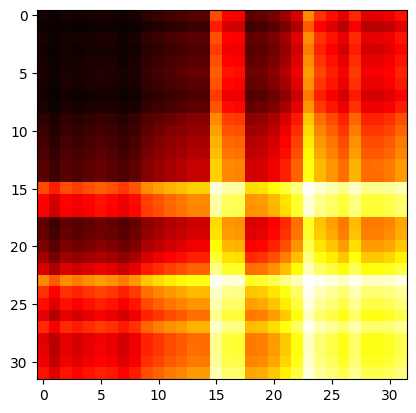

In [11]:
gaf_method='summation'

feature_data = np.array(dataset['Close'])
print(len(dataset['Close']))
#print("feature_dataset_array",feature_data)
#print("len datapoints in dataset",len(feature_data))

np.set_printoptions(threshold=np.inf)
gaf_images,price_list= generate_gaf_images(feature_data,gaf_img_sz=32, method=gaf_method)

print("",gaf_images.shape)
plt.imshow(gaf_images[0],cmap='hot')
#print("gaf_images.shape",gaf_images.shape,"data points in images",gaf_images.size, "gaf image [0] shape",gaf_images[0].shape, "data points in image [0]",gaf_images[0].size)
#print("gasf image[0] data",gaf_images[0])
#print("Gasf data",gasf_images)

np.set_printoptions()

shape images array (1, 1, 5, 491, 32, 32) shape image (32, 32)


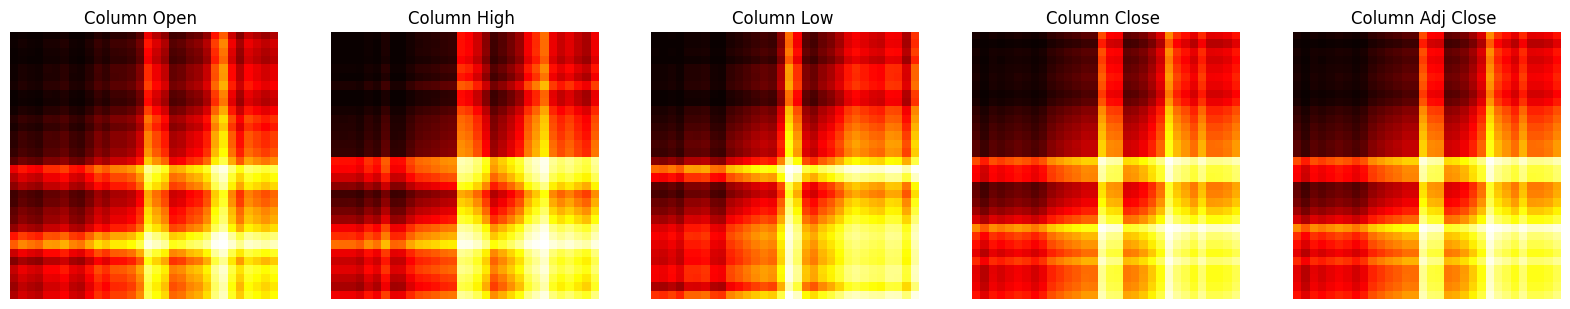

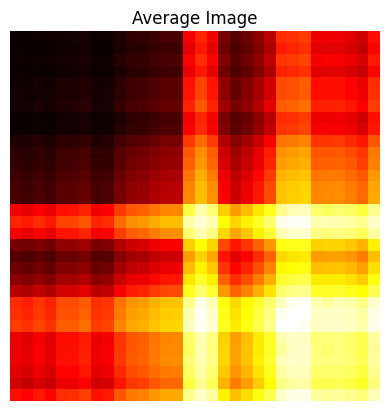

In [ ]:
images_array=np.array(feature_image_dataset_list)
prices_array=np.array(feature_price_dataset_list)
labels_array=np.array(feature_label_dataset_list)

# Plot the first image of each column
fig, axes = plt.subplots(nrows=1, ncols=cols_used_count, figsize=(20, 6))
for ax in axes:
    ax.set_aspect('equal')

#EXPLANATION SHAPE
#shape images array (1, 1, 5, 491, 32, 32)
#I get 16 images (32x32) for 524 data points, i.e. close full price series.
#Since I create images for a sliding window of price series, I request ~30 time series into images
#30*16=480~491 -  difference due to smaller last window
print("shape images array",images_array.shape,"shape image",images_array[0][0][0][0].shape)
for i in range(cols_used_count):
    axes[i].imshow(images_array[0][0][i][0], cmap='hot')
    axes[i].set_title(f"Column {cols_used[i]} ")

#average first image of all features
#interval_between_features = images_array[0][0][0][0][0].shape
average_images = []
for i in range(cols_used_count):
    average_images.append(images_array[0][0][i][0])
    #print("this image shape",images_array[0, image_index].shape)

average_image = np.mean(average_images, axis=0)

# Hide axes
for ax in axes:
    ax.axis('off')

# Plot the average image separately
plt.figure()  # Create a new figure for the average image
plt.imshow(average_image, cmap='hot')
plt.title("Average Image")
plt.axis('off')  # Hide axes
plt.show()

## Generate images for open, high, low, close and adj close prices

We transpose the resulting image list to represent:
+ 16: number of images
+ 5: number of image channels/features. Each image has 5 ="Open", "High", "Low", "Close", and "Adj Close"
+ 32: image height
+ 32: image width

In [12]:
np.set_printoptions(threshold=np.inf)

cols_used = ["Open", "High", "Low", "Close", "Adj Close"]
cols_used_count = sum(column_name in cols_used for column_name in dataset.columns)

def generate_multiple_feature_images(dataset, image_size=32, method="summation", sample_range = (0, 1)):
    
    feature_image_dataset_list=[[] for _ in range(len(cols_used))]
    feature_price_dataset_list=[[] for _ in range(len(cols_used))] #="Open", "High", "Low", "Close" , "Adj Close"
    feature_label_dataset_list=[] #next value for each chunk of ="Open", "High", "Low", "Close" , "Adj Close"
    
    column_idx = 0

    for idx, column_name in enumerate(dataset.columns):

      #create open, high, low and close images
      if column_name in ["Open", "High", "Low", "Close", "Adj Close"]:
        temp_image_list = []
        temp_price_list = []
        #print("dataset idx", idx, "len rows this data feature", len(dataset[i]), "dataset[i].shape", dataset[i].shape, "dataset i:", dataset[i])

        feature_data = dataset[column_name].values
        num_samples = len(feature_data)
        print("num_samples",num_samples)

        #print("feature_dataset_array idx", idx, "len rows feature_dataset_array", len(feature_dataset_array[0]), "shape",feature_dataset_array.shape, "feature_dataset_array:", feature_dataset_array)
        
        # generate_gaf_images generates images from full dataset according to image_size
        # however, we loop by data_chunk so each chunk represents the price series that we slide by one day forward
        # and generate an image for each slice
        # TODO: parallelism
        # we add cushion to slide the window forward
        print(f"Target number of chunks to create an image for Feature {column_name}",num_samples - (image_size+1))
        for cur_chunk in range(num_samples - (image_size+1)):
          
          #chunk size of image size
          data_chunk = feature_data[cur_chunk:cur_chunk+image_size]
          
          #append gaf image to image list. store price feature values in price list
          gaf_images, price_list = generate_gaf_images(data_chunk, gaf_img_sz=image_size, method=method, sample_range=sample_range)
          temp_image_list.append(gaf_images)
          
          # if(cur_chunk==0):
          #   print("Price Data Pre-Gaf: i", cur_chunk, "len",len(data_chunk), "shape", feature_data.shape, "data",data_chunk)
          #   print("Image Returned: idx", idx, "image size", gaf_images.size, f"first {image_size} image vals", gaf_images.flatten()[:image_size])
          
          temp_price_list.append(price_list)
          
          #get next single value after the chunk as label to list
          if(column_name == "Open"):
            feature_label_dataset_list.append(cur_chunk + image_size + 1)
        
        feature_image_dataset_list[column_idx].append(temp_image_list)
        feature_price_dataset_list[column_idx].append(price_list)
        column_idx += 1


    print("len images",len(feature_image_dataset_list),"len price list",len(feature_price_dataset_list), "len labels", len(feature_label_dataset_list)) # 2455=total range*5
    
    feature_image_dataset_list = np.array(feature_image_dataset_list) 
    print("Shape of images before transpose:", feature_image_dataset_list.shape)
    
    #transpose image for CNN
    #(5, 1, 491, 1, 32, 32)
    feature_image_dataset_list= np.transpose(feature_image_dataset_list, (1, 3, 0, 2, 4, 5))
    print("Shape of images after transpose:", feature_image_dataset_list.shape)

    return feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list

#Generate images from dataset
gaf_method="summation"
sample_range = (0, 1)
image_size = 32 #(x,y)
feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list = generate_multiple_feature_images(dataset, image_size=image_size, method=gaf_method, sample_range=sample_range)

print("shape [0] set",np.array(feature_image_dataset_list[0]).shape)

np.set_printoptions()


num_samples 524
Target number of chunks to create an image for Feature Open 491
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 32)
gaf_image (1, 32, 

## Visual representation of feature images for the same time range

Bottom image averages depth values of feature images (channels)

shape images array (1, 1, 5, 491, 32, 32) shape image (32, 32)


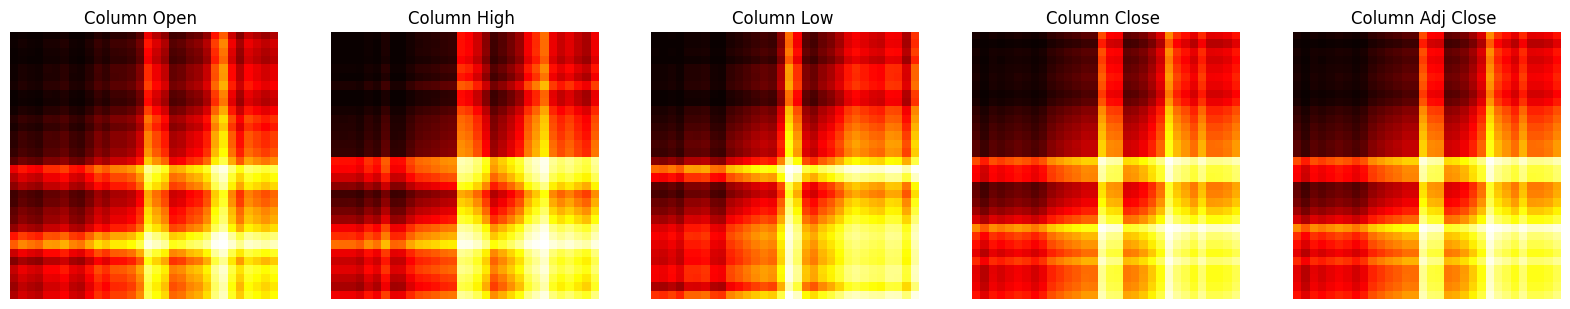

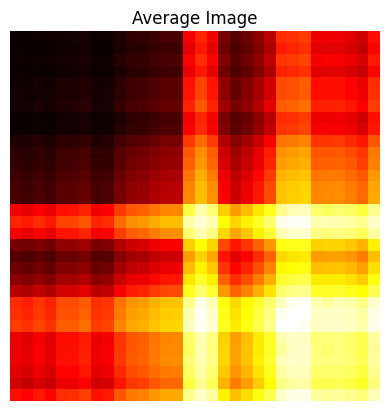

In [13]:
images_array=np.array(feature_image_dataset_list)
prices_array=np.array(feature_price_dataset_list)
labels_array=np.array(feature_label_dataset_list)

# Plot the first image of each column
fig, axes = plt.subplots(nrows=1, ncols=cols_used_count, figsize=(20, 6))
for ax in axes:
    ax.set_aspect('equal')

#EXPLANATION SHAPE
#shape images array (1, 1, 5, 491, 32, 32)
#I get 16 images (32x32) for 524 data points, i.e. close full price series.
#Since I create images for a sliding window of price series, I request ~30 time series into images
#30*16=480~491 -  difference due to smaller last window
print("shape images array",images_array.shape,"shape image",images_array[0][0][0][0].shape)
for i in range(cols_used_count):
    axes[i].imshow(images_array[0][0][i][0], cmap='hot')
    axes[i].set_title(f"Column {cols_used[i]} ")

#average first image of all features
#interval_between_features = images_array[0][0][0][0][0].shape
average_images = []
for i in range(cols_used_count):
    average_images.append(images_array[0][0][i][0])
    #print("this image shape",images_array[0, image_index].shape)

average_image = np.mean(average_images, axis=0)

# Hide axes
for ax in axes:
    ax.axis('off')

# Plot the average image separately
plt.figure()  # Create a new figure for the average image
plt.imshow(average_image, cmap='hot')
plt.title("Average Image")
plt.axis('off')  # Hide axes
plt.show()

## Prepare Training/Testing Datasets for Neural Network

Apply Transform to image to convert to tensor and normalize

In [14]:
def SetTransform(normalize_ftor=0.5,resolution_x=32,resolution_y=32):
    return transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([normalize_ftor], [normalize_ftor])
    #transforms.Resize((resolution_x, resolution_y))
    ])

In [15]:
feature_image_dataset_list_f32 = np.array(images_array).astype(np.float32)
#images_array = np.transpose(feature_image_dataset_list, (1, 0, 2, 3))

scaler = StandardScaler()
labels_array = np.array(labels_array)#.astype(np.float32)
reshaped_labels_array = labels_array.reshape(-1, 1)
labels_scaled_list_f32 = scaler.fit_transform(reshaped_labels_array).reshape(-1,).astype(np.float32)

print(images_array.shape)

(1, 1, 5, 491, 32, 32)


Prepare features data (close, high, low, etc) for Dataloader

In [16]:
class DataPrep(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        self.transform = SetTransform()

    def __len__(self):
      return len(self.inputs)

    def __getitem__(self, index):
        X = self.inputs[index]
        Y = self.labels[index]
        return X, Y
  
    def prepare_ordered_dataset(self):
        x = []
        y = []
        #print("len inputs", len(self.inputs), self.inputs.shape, self.inputs.shape[0])
        for feature in range(self.inputs.shape[0]):
            #print("feature",feature,self.inputs[feature].shape[0])
            for image in range(self.inputs[feature].shape[0]):
                #print("feature-image",feature,image,"len image",len(self.inputs[feature][image]))
                #print("size image",self.inputs[feature][image].size)
                #print("label",self.labels[image])
                self.inputs[feature][image] = self.transform(self.inputs[feature][image])
                x.append(np.expand_dims(self.inputs[feature][image], axis=0))
                y.append(self.labels[image])
                #print(self.labels[image])
                #print(self.inputs[feature][image].shape)
        
        #cnn requests labels size (4,1) instead of (4)
        y = np.expand_dims(y, axis=1) 
        #print("size self",self.inputs[0].shape,self.inputs[1].shape)
        dataset = [(img, label) for img, label in zip(x, y)]
        return dataset
        
        #return np.array(x),np.array(y)
    
    def split_data(self,dataset, batch_size=10, test_size=0.2, train_shuffle=False):
        num_samples = len(dataset)
        #print("numsamples",num_samples)
        num_test_samples = int(test_size * num_samples)
        num_train_samples = num_samples - num_test_samples
        #print("num_train_samples",num_train_samples)
        indices = np.random.permutation(num_samples)
        train_indices = indices[:num_train_samples]
        test_indices = indices[num_train_samples:]

        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler,shuffle=train_shuffle)
        test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

        sample_batch = next(iter(train_loader))
        input_shape = sample_batch[0].shape
        label_shape = sample_batch[1].shape
        print("input_shape",input_shape,"label_shape",label_shape)

        return train_loader, test_loader

In [17]:
def Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, train_shuffle=False, batch_size=10):

    print(feature_image_dataset_list_f32[0][0].shape, feature_image_dataset_list_f32[0][0].shape[0])

    #reshape for cnn
    reshaped_feature_image_dataset_list_f32 = np.expand_dims(feature_image_dataset_list_f32[0][0].reshape(-1, *feature_image_dataset_list_f32[0][0].shape[2:]), axis=1)
    #print("res",reshaped_feature_image_dataset_list_f32.shape)

    dataPreObject = DataPrep(reshaped_feature_image_dataset_list_f32, labels_scaled_list_f32)
    #print("dataprep image:",dataPreObject[0][0].shape,"label",dataPreObject[0][1].size)

    #print("feature_image_dataset_list_f32",feature_image_dataset_list_f32[0][0].shape)
    #print("labels_scaled_list_f32",labels_scaled_list_f32.shape)
    dataset = dataPreObject.prepare_ordered_dataset()

    # for c in range(len(dataset[0])):
    #     print(f"size labels {c}",dataset[1][c].size)
    #     print(f"size image {c}",dataset[0][c].shape)

    batch_size = batch_size
    train_loader, test_loader = dataPreObject.split_data(dataset, 
                                                         batch_size=batch_size,
                                                         train_shuffle=train_shuffle)

    # for e in train_loader:
    #     print("type",type(e))
    #     print("imga",e[0].shape,e[0].size)
    #     print("label",e[1].shape,e[1].size)

    return train_loader,test_loader
    

train_loader,test_loader = Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32)

(5, 491, 32, 32) 5
input_shape torch.Size([10, 1, 32, 32]) label_shape torch.Size([10, 1])


## CNN Design

dynamically calulate the shape of layers outputs

In [18]:
def conv_output_shape_dynamic(h_w, kernel_size=(1,1), stride=1):
        h = floor( (h_w[0] - kernel_size[0])/ stride) + 1
        w = floor( (h_w[1] - kernel_size[1])/ stride) + 1
        return h, w

In [19]:
class Net(nn.Module):
    def __init__(self,name="LeNet5Blend",
                 filter_size_1=(2, 2), filter_size_2=(2, 3), filter_size_3=(2, 3), stride=2,
                 output_conv_1=80,output_conv_2=16, output_FC_1=120,output_FC_2=84,
                 image_resolution_x=32,image_resolution_y=32,final_FCLayer_outputs=1,
                 dropout_probab=0):
        super(Net, self).__init__()
        
        if name:
            self.name = name
        self.totalparams = 0
        self.output_conv_2=output_conv_2
        self.conv_output_size=0
        print();print("Convos & dropoutP:",output_conv_1,output_conv_2, dropout_probab)
        
        #num channels input, num channels output, filter size 
        self.conv1 = nn.Conv2d(1, output_conv_1, filter_size_1,stride=1)
        #filtersize,stride.
        #maxpool acts the same way in each channel, so doesn't need to be fed the num channels of the input
        self.pool = nn.MaxPool2d(kernel_size=filter_size_2, stride=stride)
        self.conv2 = nn.Conv2d(output_conv_1, output_conv_2, filter_size_3,stride=1)

        H_out_1, W_out_1 = conv_output_shape_dynamic((image_resolution_y, image_resolution_x), kernel_size=filter_size_1,stride=1)
        H_out_2, W_out_2 = conv_output_shape_dynamic((H_out_1, W_out_1), kernel_size=filter_size_2,stride=stride)
        H_out_3, W_out_3 = conv_output_shape_dynamic((H_out_2, W_out_2), kernel_size=filter_size_3,stride=1)
        H_out_4, W_out_4 = conv_output_shape_dynamic((H_out_3, W_out_3), kernel_size=filter_size_2,stride=stride)
        
        print("imgres",image_resolution_x,image_resolution_y)
        print("H_out_1, W_out_1",H_out_1, W_out_1)
        print("H_out_2, W_out_2",H_out_2, W_out_2)
        print("H_out_3, W_out_4",H_out_3, W_out_3)
        print("H_out_4, W_out_4",H_out_4, W_out_4)
        print("outputconv2",output_conv_2)
        self.conv_output_size = H_out_4 * W_out_4

        #Fully connected layers and apply dropout
        self.fc1 = nn.Linear(output_conv_2*self.conv_output_size, output_FC_1)
        if(dropout_probab>0): self.dropout1 = nn.Dropout(dropout_probab)
        self.fc2 = nn.Linear(output_FC_1, output_FC_2)
        if(dropout_probab>0): self.dropout1 = nn.Dropout(dropout_probab)
        self.fc3 = nn.Linear(output_FC_2, final_FCLayer_outputs)
        
        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)
        self.totalparams=total_params

    def forward(self, x):
        #print("Input shape:", x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print("After conv1 and pooling shape:", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("After conv2 and pooling shape:", x.shape)
        #-1 takes the batch size
        x = x.view(-1,self.output_conv_2*self.conv_output_size)
        #print("After flattening shape:", x.shape)
        x = F.relu(self.fc1(x))
        #print("After fc1 shape:", x.shape)
        x = F.relu(self.fc2(x))
        #print("After fc2 shape:", x.shape)
        x = self.fc3(x)
        #print("Output shape:", x.shape)
        return x

## Train and Test CNN

Initiate hyperparameters

In [20]:
#Default hyperparameters

filter_size_1=(2, 2)
filter_size_2=(2, 3)
filter_size_3=(2, 3)

stride=2

output_conv_1=40
output_conv_2=12
output_FC_1=100
output_FC_2=70
final_FCLayer_output=1

learning_rate=0.001
momentum = 0.9

dropout_probab=0

num_epochs_input = 20

transform = SetTransform(normalize_ftor=0.5, resolution_x=32, resolution_y=32)

Instantiate Net

In [21]:
net = Net(name='Classification Net', filter_size_1=filter_size_1, filter_size_2=filter_size_2,
            filter_size_3=filter_size_3, stride=stride,
            image_resolution_x=32,image_resolution_y=32,
            output_conv_1=output_conv_1, output_conv_2=output_conv_2,
            output_FC_1=output_FC_1, output_FC_2=output_FC_2,
            final_FCLayer_outputs=final_FCLayer_output,
            dropout_probab=dropout_probab)

net.to(device)
net.parameters()


Convos & dropoutP: 40 12 0
imgres 32 32
H_out_1, W_out_1 31 31
H_out_2, W_out_2 15 15
H_out_3, W_out_4 14 13
H_out_4, W_out_4 7 6
outputconv2 12
Classification Net: total params: 60733


<generator object Module.parameters at 0x00000237CAC6C580>

Train CNN

In [22]:
#print running_loss every [x] mini-batches
mini_batch_running_loss_check = 50

def Train(learning_rate=learning_rate,momentum=momentum,
          train_loader=train_loader, net=net):
    
    print("Train params:",learning_rate,momentum)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    #criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(num_epochs_input):  

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            #get the inputs; data is a list of [inputs, labels]
            # print("image type",type(data[0]), "shape", data[0].shape)
            # print("image size",data[0].numel())
            # print("label type",type(data[1]), "shape", data[1].shape)
            # print("label size",data[1].numel())
            #print("**zero:",data[0])
            #print("type",type(data[1]),"**one:", data[1])
            #print("label pre",data[1])
            #data[1]=data[1].type(torch.LongTensor)
            #print("label post",data[1])
            inputs, labels = data[0].to(device), data[1].to(device)
            #print("at epoch",epoch,"at i",i,"emotion",labels_emotion,"person",labels_person)
            
            # for e in data[1]:
            #     print("label",e.item())
            #print("label",data[1].item())
            #labels = labels.long()

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            #print("outputs",outputs)
            loss = criterion(outputs, labels)
            if loss is not None:
                loss.backward()
                optimizer.step()

                # Print optimizer's state_dict
                # print("Optimizer's state_dict:")
                # for var_name in optimizer.state_dict():
                #     print(var_name, "\t", optimizer.state_dict()[var_name])

                # print statistics
                running_loss += loss.item()
                if i % mini_batch_running_loss_check == (mini_batch_running_loss_check-1):    # print every 20 mini-batches
                    print('[%d, %5d] Cum loss: %.6f' %
                        (epoch + 1, i + 1, running_loss / mini_batch_running_loss_check)) 
                    running_loss = 0.0

                if loss.item() < 0.000001:
                    print("Loss is less than 0.0001. Stopping training.")
                    return loss
                
    return loss

loss = Train()
print(loss)

Train params: 0.001 0.9
[1,    50] Cum loss: 0.422532
[1,   100] Cum loss: 0.020577
[1,   150] Cum loss: 0.012949
[2,    50] Cum loss: 0.005529
[2,   100] Cum loss: 0.003281
[2,   150] Cum loss: 0.002941
[3,    50] Cum loss: 0.002459
[3,   100] Cum loss: 0.001525
[3,   150] Cum loss: 0.001348
[4,    50] Cum loss: 0.002006
[4,   100] Cum loss: 0.001162
[4,   150] Cum loss: 0.001214
[5,    50] Cum loss: 0.001000
[5,   100] Cum loss: 0.000983
[5,   150] Cum loss: 0.001023
[6,    50] Cum loss: 0.000840
[6,   100] Cum loss: 0.001063
[6,   150] Cum loss: 0.000783
[7,    50] Cum loss: 0.000632
[7,   100] Cum loss: 0.000698
[7,   150] Cum loss: 0.000932
[8,    50] Cum loss: 0.000795
[8,   100] Cum loss: 0.001160
[8,   150] Cum loss: 0.000605
[9,    50] Cum loss: 0.000486
[9,   100] Cum loss: 0.000661
[9,   150] Cum loss: 0.000858
[10,    50] Cum loss: 0.000975
[10,   100] Cum loss: 0.000842
[10,   150] Cum loss: 0.000799
[11,    50] Cum loss: 0.000773
[11,   100] Cum loss: 0.000654
[11,   150]

## Test CNN Results

In [23]:
def Test(test_loader=test_loader, net=net):
    predicted = []
    actual = []
    correct = 0
    total = 0

    for i, data in enumerate(test_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        
        predicted.append(outputs)
        actual.append(labels)

        predicted_rounded = torch.round(outputs.data * 100) / 100
        actual_rounded = torch.round(labels.data * 100) / 100
        correct += torch.sum(torch.abs(predicted_rounded - actual_rounded) <= 0.01).item()
        total += len(predicted_rounded)
    #Pct correct pred
    accuracy = (correct / total) * 100
    print(f"Percentage of predictions within 2 decimal places: {accuracy:.2f}%")

    #print(predicted,actual)
    return predicted,actual,accuracy

Test Results

In [24]:
predicted, actual, accuracy = Test()

predicted = torch.cat(predicted)
actual = torch.cat(actual)
absolute_diff = torch.abs(predicted - actual)
percentage_diff = (absolute_diff / torch.abs(actual)) * 100

predicted_np = predicted.cpu().detach().numpy()
actual_np = actual.cpu().detach().numpy()
percentage_diff_np = percentage_diff.cpu().detach().numpy()

# Create a dictionary with the data
data = {
    'Predicted': predicted_np.flatten(),
    'Actual': actual_np.flatten(),
    'Percentage Difference': percentage_diff_np.flatten()
}

# Create the DataFrame
df = pd.DataFrame(data)
df['Percentage Difference'] = df['Percentage Difference'].map(lambda x: f"{x:.3f}%")

print(df)

df['Percentage Difference'] = df['Percentage Difference'].str.rstrip('%').astype(float)

average_percentage_diff = df['Percentage Difference'].mean()
print(f"Accuracy: {accuracy:.3f} Average Percentage Difference: {average_percentage_diff:.3f}% for timeseries of {len(df)} datapoints across {len(cols_used)} features: {cols_used}.")

Percentage of predictions within 2 decimal places: 2.85%
     Predicted    Actual Percentage Difference
0    -1.704265 -1.728527                1.404%
1    -1.703422 -1.728527                1.452%
2    -1.711620 -1.728527                0.978%
3    -1.710918 -1.728527                1.019%
4    -1.698964 -1.728527                1.710%
..         ...       ...                   ...
486  -1.698739 -1.728527                1.723%
487  -1.685047 -1.728527                2.515%
488  -1.724468 -1.728527                0.235%
489  -1.714897 -1.728527                0.789%
490  -1.700616 -1.728527                1.615%

[491 rows x 3 columns]
Accuracy: 2.851 Average Percentage Difference: 1.377% for timeseries of 491 datapoints across 5 features: ['Open', 'High', 'Low', 'Close', 'Adj Close'].


## Bayesian Optimization for CNN Hyperparameters

In [25]:
def CNN_Optimization(output_conv_1, 
                     output_conv_2,
                     dropout_probab,
                     learning_rate,
                     train_loader,test_loader):
    
    output_conv_1 = int(output_conv_1)
    output_conv_2 = int(output_conv_2)
    
    net = Net(output_conv_1=output_conv_1, output_conv_2=output_conv_2,dropout_probab=dropout_probab)
    net.to(device)

    Train(learning_rate=learning_rate, train_loader=train_loader, net=net)

    predicted,actual,accuracy = Test(test_loader=test_loader,net=net)
    print("accuracy received",accuracy)

    return accuracy

In [26]:
from bayes_opt import BayesianOptimization
from functools import partial

def Optimize():
    
    Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, train_shuffle=False, batch_size=10)
    
    cnn_correct_pct = partial(CNN_Optimization, train_loader = train_loader, test_loader = test_loader)

    # Bounded region of parameter space
    pbounds = {'output_conv_1': (40, 80), 'output_conv_2': (8, 16), 'learning_rate': (0.001, 0.01), 'dropout_probab': (0.0, 0.5)}

    optimizer = BayesianOptimization(
        f=cnn_correct_pct,
        pbounds=pbounds,
        random_state=1,
        )

    #n_iter:steps of bayesian optimization you want to perform
    #init_points:steps of random exploration
    optimizer.maximize(init_points=10, n_iter=10,)

    for i, res in enumerate(optimizer.res):
        print("Iteration {}: \n\t{}".format(i, res))

    print(optimizer.max)

In [27]:
Optimize()

(5, 491, 32, 32) 5
input_shape torch.Size([10, 1, 32, 32]) label_shape torch.Size([10, 1])
|   iter    |  target   | dropou... | learni... | output... | output... |
-------------------------------------------------------------------------

Convos & dropoutP: 40 10 0.208511002351287
imgres 32 32
H_out_1, W_out_1 31 31
H_out_2, W_out_2 15 15
H_out_3, W_out_4 14 13
H_out_4, W_out_4 7 6
outputconv2 10
LeNet5Blend: total params: 63379
Train params: 0.007482920440979424 0.9
[1,    50] Cum loss: 2.626901
[1,   100] Cum loss: 0.010061
Loss is less than 0.0001. Stopping training.
Percentage of predictions within 2 decimal places: 100.00%
accuracy received 100.0
| 1         | 100.0     | 0.2085    | 0.007483  | 40.0      | 10.42     |

Convos & dropoutP: 47 10 0.07337794540855652
imgres 32 32
H_out_1, W_out_1 31 31
H_out_2, W_out_2 15 15
H_out_3, W_out_4 14 13
H_out_4, W_out_4 7 6
outputconv2 10
LeNet5Blend: total params: 63834
Train params: 0.0018310473529191804 0.9
[1,    50] Cum loss: 0.24513